# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
# Defining transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),
                                transforms.Lambda(lambda x: x.view(-1))])

# Loading the datasets
mnist_dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Defining the sizes of train, validation, and test sets
train_size = int(0.7 * len(mnist_dataset))  # 70% for training
val_size = int(0.3 * len(mnist_dataset))    # 30% for validation

# Splitting the MNIST dataset 
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# Create test set and define test dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

We decided to use ToTensor() to convert the images to tensors. Next we used the torchvision.transforms.Normalize() to normalize the images for 0.5 standard deviation and 0.5 mean. Finally, we used Lambda to flatten the images as 1D tensors.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [13]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
## Unfortunately, we did change the function as we had flattened the images in the previous cell as 1D tensors. ##
import matplotlib.pyplot as plt

def show5(img_loader):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    
    labels = batch[1][0:5]  # Get the first 5 labels
    images = batch[0][0:5]  # Get the first 5 images
    
    for i in range(5):
        print(f"Label: {int(labels[i].detach())}")  # Print the label
        
        # Reshape the flattened image back to 28x28
        image = images[i].numpy().reshape(28, 28)
        
        # Display the image
        plt.imshow(image, cmap="gray")  # Use grayscale colormap
        plt.axis('off')  # Turn off axis
        plt.show()


Label: 7


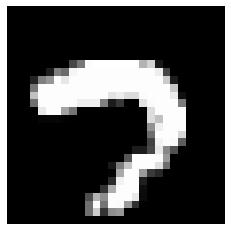

Label: 8


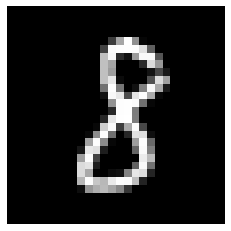

Label: 1


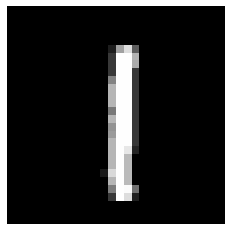

Label: 6


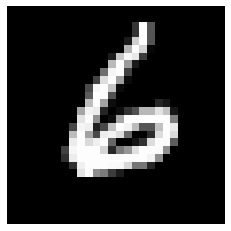

Label: 8


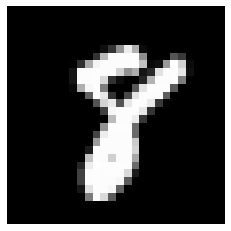

In [14]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28 * 1, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x) # Output logits without softmax, since we use CrossEntropyLoss
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [22]:
net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001) # We use SGD instead of Adam because of the small dataset.
criterion = nn.CrossEntropyLoss() # Combines LogSoftmax and NLLLoss in one single class, so it is efficient.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [23]:
# Move the model to the GPU if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

In [24]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    total_predictions = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad() # zero the parameter gradients
    
        outputs = net(inputs) # forward pass
    
        loss = criterion(outputs, labels) # compute the loss
        loss.backward() # compute gradient of the loss with respect to model parameters

        optimizer.step() # update the parameters
    
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))
    
    # The validation phase
    val_loss = 0.0
    val_correct = 0
    total_predictions = 0

    # setting the model to evaluation mode
    net.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
        print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
        val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 69.85% training loss: 0.90466
Epoch 1 validation accuracy: 87.93% validation loss: 0.39020
Epoch 2 training accuracy: 90.89% training loss: 0.30154
Epoch 2 validation accuracy: 90.62% validation loss: 0.30595
Epoch 3 training accuracy: 93.43% training loss: 0.21637
Epoch 3 validation accuracy: 93.62% validation loss: 0.21112
Epoch 4 training accuracy: 94.95% training loss: 0.16649
Epoch 4 validation accuracy: 94.84% validation loss: 0.16621
Epoch 5 training accuracy: 95.84% training loss: 0.13637
Epoch 5 validation accuracy: 94.53% validation loss: 0.17280
Epoch 6 training accuracy: 96.49% training loss: 0.11621
Epoch 6 validation accuracy: 96.08% validation loss: 0.12930
Epoch 7 training accuracy: 96.88% training loss: 0.10227
Epoch 7 validation accuracy: 96.51% validation loss: 0.11485
Epoch 8 training accuracy: 97.36% training loss: 0.08726
Epoch 8 validation accuracy: 96.52% validation loss: 0.11322
Epoch 9 training accuracy: 97.50% training loss: 0.08120

Plot the training loss (and validation loss/accuracy, if recorded).

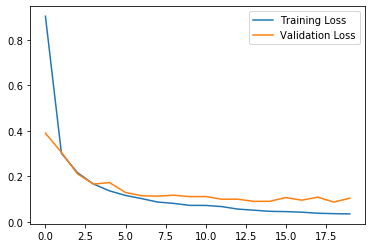

In [25]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [26]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.99%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

The training accuracy  of 99.05% is higher than the validation accuracy of 97.3%, which means that the model is slightly overfitting. Additionally, the model appears to converge by epoch 13-15, as validation accuracy and loss remain relatively stable.

In [41]:

from torch.optim import AdamW


# exprimenting with the loss function
net = Net()

# Move the model to the GPU if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

optimizer = AdamW(net.parameters(), lr=0.001, weight_decay=0.001)  # Weight decay for regularization
criterion = nn.CrossEntropyLoss() # Combines LogSoftmax and NLLLoss in one single class, so it is efficient.

In [42]:
# Early stopping parameters
patience = 3  # Stop after 3 epochs of no improvement
best_val_loss = float('inf')  # Initialize best validation loss
stop_counter = 0  # Counter for epochs with no improvement

# Number of epochs
num_epochs = 16

# Lists for loss history
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    net.train()
    train_loss = 0.0
    train_correct = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    train_accuracy = train_correct / len(train_loader.dataset) * 100
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    
    print(f"Epoch {epoch + 1} training accuracy: {train_accuracy:.2f}% training loss: {train_loss:.5f}")
    
    # Validation phase
    net.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
    
    val_accuracy = val_correct / len(val_loader.dataset) * 100
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)
    
    print(f"Epoch {epoch + 1} validation accuracy: {val_accuracy:.2f}% validation loss: {val_loss:.5f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update best loss
        stop_counter = 0  # Reset counter
    else:
        stop_counter += 1  # Increment counter if no improvement
    
    if stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break


Epoch 1 training accuracy: 83.84% training loss: 0.52206
Epoch 1 validation accuracy: 91.65% validation loss: 0.27935
Epoch 2 training accuracy: 92.88% training loss: 0.23430
Epoch 2 validation accuracy: 93.53% validation loss: 0.20846
Epoch 3 training accuracy: 94.71% training loss: 0.17247
Epoch 3 validation accuracy: 95.17% validation loss: 0.15905
Epoch 4 training accuracy: 96.05% training loss: 0.12858
Epoch 4 validation accuracy: 95.58% validation loss: 0.14395
Epoch 5 training accuracy: 96.77% training loss: 0.10281
Epoch 5 validation accuracy: 96.09% validation loss: 0.12992
Epoch 6 training accuracy: 97.23% training loss: 0.08758
Epoch 6 validation accuracy: 96.73% validation loss: 0.11018
Epoch 7 training accuracy: 97.59% training loss: 0.07552
Epoch 7 validation accuracy: 96.67% validation loss: 0.11279
Epoch 8 training accuracy: 97.81% training loss: 0.06799
Epoch 8 validation accuracy: 96.74% validation loss: 0.11098
Epoch 9 training accuracy: 98.07% training loss: 0.05806

## Final accuracy after tweaking the model


In [43]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.92%


## Saving your model
Using `torch.save`, save your model for future loading.

In [44]:
torch.save(net.state_dict(), "saved_model.pth")

# Implementing sanity checking


**This part was implemented later. So, to avoid training the model again, we will load the the already trained checkpoint right away**

In [45]:
# Assuming your model class is called Net
net = Net()

# Load the saved model
model_path = "saved_model.pth"
checkpoint = torch.load(model_path)

# Check if the 'model_state_dict' key is present in the checkpoint
if 'model_state_dict' in checkpoint:
    # Load the model's state_dict
    net.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully.")
else:
    # If the key is not present, try loading the entire state dictionary
    net.load_state_dict(checkpoint)
    print("Model loaded successfully (full state dictionary).")

# If you also saved optimizer state, you can load it as well
if 'optimizer_state_dict' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# If you saved other information such as training epochs or loss history, you can load them too
# For example, if you saved the number of epochs
if 'epoch' in checkpoint:
    epoch = checkpoint['epoch']

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()


Model loaded successfully (full state dictionary).


<ipython-input-45-50ef9494e2b8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

## Visualizing the predications (actual vs predicted)

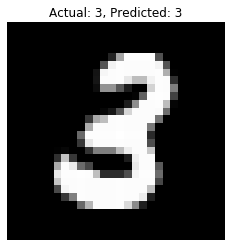

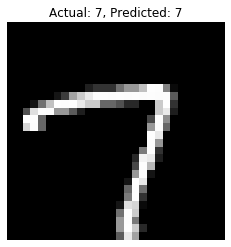

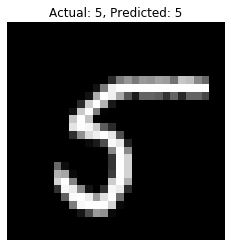

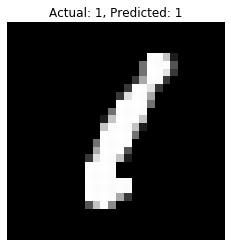

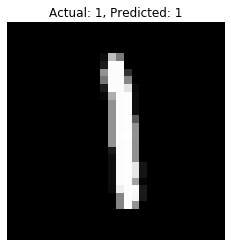

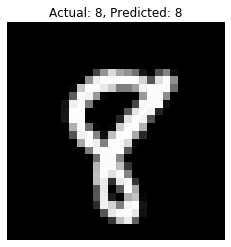

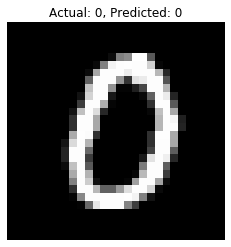

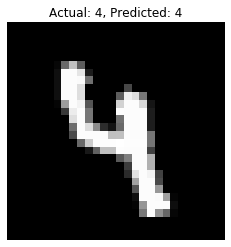

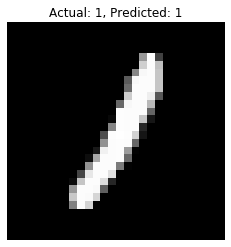

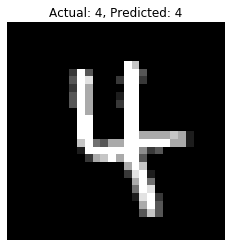

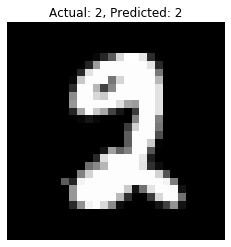

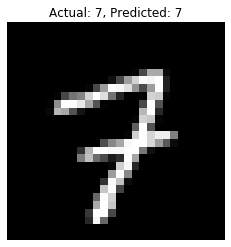

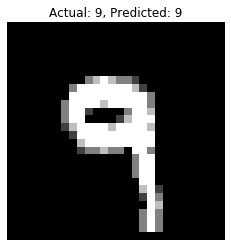

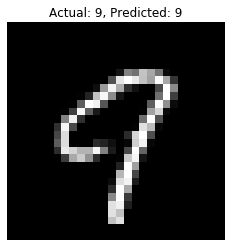

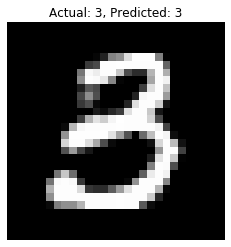

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

def visualize_results(model, dataloader, device):
    model.eval()

    # Get the total number of samples in the dataset
    total_samples = len(dataloader.dataset)

    # Randomly select 15 indices
    random_indices = random.sample(range(total_samples), 15)

    with torch.no_grad():
        for idx in random_indices:
            inputs, labels = dataloader.dataset[idx]
            
            # Reshape inputs to match model input and send to device
            inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension
            labels = torch.tensor([labels]).to(device)

            # Model prediction
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert tensors to NumPy arrays
            inputs = inputs.cpu().numpy().reshape(28, 28)  # Reshape from 1D to 28x28
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()

            # Display the sample
            plt.imshow(inputs, cmap='gray')  # Show the reshaped image
            plt.title(f"Actual: {labels.item()}, Predicted: {preds[0]}")
            plt.axis('off')
            plt.show()

# Call the function with the model and the test dataloader
visualize_results(net, test_loader, device)


## Confusion matrix

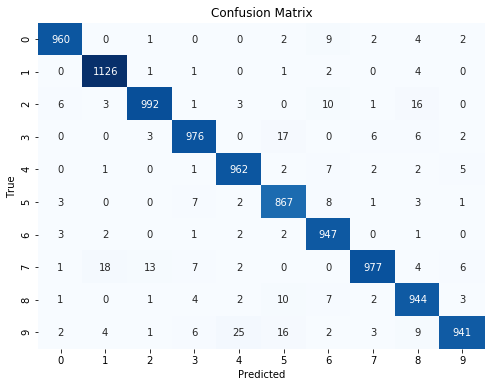

In [49]:
# Initialize variables
total_predictions = 0
correct_predictions = 0
all_preds = []
all_labels = []
for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    
    # Append predictions and labels for confusion matrix
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()